In [68]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/11785/hw4/part1

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/MyDrive/11785/hw4/part1'
/content/gdrive/MyDrive/11785/hw4/part1


In [ ]:
!pwd

/content


In [ ]:
!kill -9 -1

In [ ]:
!nvidia-smi

Mon Apr 26 10:10:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import time
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
# from tests import test_prediction, test_generation
import random
from tqdm import tqdm

In [ ]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
num_workers = 2 if cuda else 0
print("Cuda = "+str(cuda)+" with num_workers = "+str(num_workers))

Cuda = True with num_workers = 2


In [ ]:
def log_softmax(x, axis):
    ret = x - np.max(x, axis=axis, keepdims=True)
    lsm = np.log(np.sum(np.exp(ret), axis=axis, keepdims=True))
    return ret - lsm


def array_to_str(arr, vocab):
    return " ".join(vocab[a] for a in arr)


def test_prediction(out, targ):
    out = log_softmax(out, 1)
    nlls = out[np.arange(out.shape[0]), targ]
    nll = -np.mean(nlls)
    return nll

def test_generation(inp, pred, vocab):
    outputs = u""
    for i in range(inp.shape[0]):
        w1 = array_to_str(inp[i], vocab)
        w2 = array_to_str(pred[i], vocab)
        outputs += u"Input | Output #{}: {} | {}\n".format(i, w1, w2)
    return outputs

In [ ]:
# load all that we need

dataset = np.load('../dataset/wiki.train.npy', allow_pickle=True)
devset = np.load('../dataset/wiki.valid.npy', allow_pickle=True)
fixtures_pred = np.load('../fixtures/prediction.npz')  # dev
fixtures_gen = np.load('../fixtures/generation.npy')  # dev
fixtures_pred_test = np.load('../fixtures/prediction_test.npz')  # test
fixtures_gen_test = np.load('../fixtures/generation_test.npy')  # test
vocab = np.load('../dataset/vocab.npy')

In [ ]:
len(dataset[245])

4949

In [ ]:
# data loader

class LanguageModelDataLoader(DataLoader):
    """
        TODO: Define data loader logic here
    """
    def __init__(self, dataset, batch_size, seq_len, shuffle=True):
        # concatenate and group data into sequences here to be more efficient
        data_string = dataset[0]
        for i in range(1, len(dataset)):
          data_string = np.concatenate((data_string, dataset[i]), axis=0)
        data = []
        for i in range(len(data_string) // seq_len):
          data.append([data_string[i*seq_len:(i+1)*seq_len], data_string[i*seq_len+1:(i+1)*seq_len+1]])
        self.data = np.array(data)    # numpy array, - * 2 * seq_len
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.shuffle = shuffle


    def __iter__(self):
        # concatenate your articles and build into batches
        indices = list(range(len(self.data)))
        if self.shuffle:
          random.shuffle(indices)
        i = 0
        while (i+1) * self.batch_size <= len(indices):
          span = indices[i*self.batch_size:(i+1)*self.batch_size]
          batch = self.data[span]
          input = torch.from_numpy(batch[:,0,:])
          label = torch.from_numpy(batch[:,1,:])
          yield input.long(), label.long()  # 2 tensors of shape (batch_size, seq_len)
          i += 1
        
        

In [ ]:
loader_test = LanguageModelDataLoader(dataset, 64, 200)

In [ ]:
vocab[fixtures_pred['inp']]

In [ ]:
# model

class LanguageModel(nn.Module):
    """
        TODO: Define your model here
    """
    def __init__(self, vocab_size, embed_size, hidden_size, nlayers):
        super(LanguageModel, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.nlayers = nlayers
        self.embedding = nn.Embedding(vocab_size, embed_size) # Embedding layer
        self.rnn = nn.LSTM(input_size=embed_size, hidden_size=hidden_size, num_layers=nlayers, batch_first=True)  # RNN layer
        self.scoring = nn.Linear(hidden_size, vocab_size) # Projection layer
        self.scoring.weight = self.embedding.weight   # weight tying


    # given word sequences, predict their output sequences
    def forward(self, x):
        # Feel free to add extra arguments to forward (like an argument to pass in the hiddens)
        # x.shape is batch_size * seq_len
        batch_size = x.shape[0]
        seq_len = x.shape[1]
        embed = self.embedding(x) # batch_size * seq_len * embed_size
        hidden = None
        output_lstm, hidden = self.rnn(embed, hidden) # batch_size * seq_len * hidden_size
        output_lstm_flatten = output_lstm.reshape(-1, self.hidden_size) # (batch_size * seq_len) * hidden_size
        output_flatten = self.scoring(output_lstm_flatten) # (batch_size * seq_len) * vocab_size
        return output_flatten.reshape(batch_size, seq_len, self.vocab_size)  # batch_size * seq_len * vocab_size


    # given word sequences, generate following words
    def generate(self, x, n_words):
        # performs greedy search to extract and return words (one sequence).
        generated_words = []
        embed = self.embedding(x) # batch_size * seq_len * embed_size
        hidden = None
        output_lstm, hidden = self.rnn(embed, hidden) # batch_size * seq_len * hidden_size
        output = output_lstm[:,-1] # batch_size * hidden_size, last predicted word embedding of every sample
        scores = self.scoring(output) # batch_size * vocab_size
        _, current_word = torch.max(scores, dim=1) # (batch_size, ), last predicted words
        generated_words.append(current_word)
        if n_words > 1:
            for i in range(n_words-1):
                # use hidden here to pass previous hidden states to the generation of following words
                embed = self.embedding(current_word.unsqueeze(1)) # batch_size * 1 * embed_size
                output_lstm, hidden = self.rnn(embed, hidden) # batch_size * 1 * hidden_size
                output = output_lstm[:,-1] # batch_size * hidden_size
                scores = self.scoring(output) # batch_size * vocab_size
                _, current_word = torch.max(scores, dim=1) # (batch_size, )
                generated_words.append(current_word)
        return torch.stack(generated_words, dim=1)

    


In [ ]:
# model trainer

class LanguageModelTrainer:
    def __init__(self, model, loader, max_epochs=1, run_id='exp'):
        """
            Use this class to train your model
        """
        # feel free to add any other parameters here
        self.model = model.to(device)
        self.loader = loader
        self.train_losses = []
        self.val_losses = []
        self.predictions = []
        self.predictions_test = []
        self.generated_logits = []
        self.generated = []
        self.generated_logits_test = []
        self.generated_test = []
        self.epochs = 0
        self.max_epochs = max_epochs
        self.run_id = run_id
        
        # TODO: Define your optimizer and criterion here
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001, weight_decay=1e-6)
        self.criterion = nn.CrossEntropyLoss()

    def train(self):
        self.model.train() # set to training mode
        epoch_loss = 0
        num_batches = 0
        for batch_num, (inputs, targets) in tqdm(enumerate(self.loader)):
            epoch_loss += self.train_batch(inputs, targets)
        epoch_loss = epoch_loss / (batch_num + 1)
        self.epochs += 1
        print('[TRAIN]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, epoch_loss))
        self.train_losses.append(epoch_loss)

    def train_batch(self, inputs, targets):
        """ 
            TODO: Define code for training a single batch of inputs
        
        """
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = self.model(inputs)
        loss = self.criterion(outputs.reshape(-1,outputs.size(2)), targets.reshape(-1)) # Loss of the flattened outputs
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss

    
    def test(self):
        # don't change these
        self.model.eval() # set to eval mode
        predictions = TestLanguageModel.prediction(fixtures_pred['inp'], self.model) # get predictions
        self.predictions.append(predictions)
        generated_logits = TestLanguageModel.generation(fixtures_gen, 10, self.model) # generated predictions for 10 words
        generated_logits_test = TestLanguageModel.generation(fixtures_gen_test, 10, self.model)
        nll = test_prediction(predictions, fixtures_pred['out'])
        generated = test_generation(fixtures_gen, generated_logits, vocab)
        generated_test = test_generation(fixtures_gen_test, generated_logits_test, vocab)
        self.val_losses.append(nll)
        
        self.generated.append(generated)
        self.generated_test.append(generated_test)
        self.generated_logits.append(generated_logits)
        self.generated_logits_test.append(generated_logits_test)
        
        # generate predictions for test data
        predictions_test = TestLanguageModel.prediction(fixtures_pred_test['inp'], self.model) # get predictions
        self.predictions_test.append(predictions_test)
            
        print('[VAL]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, nll))
        return nll

    def save(self):
        # don't change these
        model_path = os.path.join('experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()},
            model_path)
        np.save(os.path.join('experiments', self.run_id, 'predictions-{}.npy'.format(self.epochs)), self.predictions[-1])
        np.save(os.path.join('experiments', self.run_id, 'predictions-test-{}.npy'.format(self.epochs)), self.predictions_test[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-{}.npy'.format(self.epochs)), self.generated_logits[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-test-{}.npy'.format(self.epochs)), self.generated_logits_test[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}-test.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated_test[-1])


In [ ]:
a = torch.ones(4,2,3)
a = a.view(-1)
a.shape

torch.Size([24])

In [ ]:
class TestLanguageModel:
    # predict the next word following the given word sequence
    # input: batch_size * seq_len
    # output: batch_size * vocab_size, float tensor consisting of logits
    def prediction(inp, model):
        """
            TODO: write prediction code here
            
            :param inp:
            :return: a np.ndarray of logits
        """
        inp = torch.from_numpy(inp).long().to(device)
        out = model(inp)
        return out[:,-1,:].cpu().detach().numpy()

      
    # generate the following words of the given word sequence
    # input: batch_size * seq_len
    # output: batch_size * forward, int tensor consisting of word indices
    def generation(inp, forward, model):
        """
            TODO: write generation code here

            Generate a sequence of words given a starting sequence.
            :param inp: Initial sequence of words (batch size, length)
            :param forward: number of additional words to generate
            :return: generated words (batch size, forward)
        """        
        inp = torch.from_numpy(inp).long().to(device)
        return model.generate(inp, forward).cpu().detach().numpy()
        

In [ ]:
# TODO: define other hyperparameters here

NUM_EPOCHS = 5
BATCH_SIZE = 64
EMBED_SIZE = 256
SEQ_LEN = 40


In [ ]:
run_id = str(int(time.time()))
if not os.path.exists('./experiments'):
    os.mkdir('./experiments')
os.mkdir('./experiments/%s' % run_id)
print("Saving models, predictions, and generated words to ./experiments/%s" % run_id)

Saving models, predictions, and generated words to ./experiments/1619442897


In [ ]:
!nvidia-smi

Mon Apr 26 13:15:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    61W / 149W |   8962MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
model = LanguageModel(vocab_size=len(vocab), embed_size=EMBED_SIZE, hidden_size=EMBED_SIZE, nlayers=3) # set hidden_size=embed_size for weight tying
loader = LanguageModelDataLoader(dataset=dataset, batch_size=BATCH_SIZE, seq_len=SEQ_LEN, shuffle=True)
trainer = LanguageModelTrainer(model=model, loader=loader, max_epochs=NUM_EPOCHS, run_id=run_id)

In [ ]:
best_nll = 1e30 
for epoch in range(NUM_EPOCHS):
    trainer.train()
    nll = trainer.test()
    if nll < best_nll:
        best_nll = nll
        print("Saving model, predictions and generated output for epoch "+str(epoch)+" with NLL: "+ str(best_nll))
        trainer.save()
    

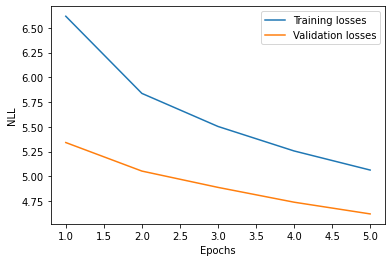

In [ ]:
# Don't change these
# plot training curves
plt.figure()
plt.plot(range(1, trainer.epochs + 1), trainer.train_losses, label='Training losses')
plt.plot(range(1, trainer.epochs + 1), trainer.val_losses, label='Validation losses')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

In [ ]:
# see generated output
print (trainer.generated[-1]) # get last generated output

In [ ]:
!make runid=1619442897 epoch=5

In [69]:
!pwd

/content/gdrive/My Drive/11785/hw4/part1
